In [1]:
# Imports

import os
from pathlib import Path
import sys
from typing import *
import joblib

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import shutil

from pprint import pprint

# Hacky way to resolve project paths
sys.path.append(str(Path(os.getcwd()).parents[0]))
sys.path.append(str(Path(os.getcwd()).parents[1]))

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches
import numpy as np
import tifffile as tf
import torch

from PIL import Image

from ubteacher.modeling.meta_arch.rcnn import TwoStagePseudoLabGeneralizedRCNN
from ubteacher.modeling.meta_arch.ts_ensemble import EnsembleTSModel
from ubteacher.engine.trainer import UBRCNNTeacherTrainer

from detectron2.config import get_cfg
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog

import ROI_detection2.utils.train_utils as train_utils

from ubteacher.config import add_ubteacher_config;

In [3]:
image_file = '/home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/datasets/coco/test2017/000000001685.jpg'
img_preview = Image.open(image_file)
img = np.transpose(img_preview, (2, 0, 1))
img_tensor = torch.from_numpy(img)
print(img_tensor.shape)
inputs = [{"image": img_tensor, "height": img.shape[1], "width": img.shape[2]}]

torch.Size([3, 640, 480])


In [4]:
# Load trained model from config and weights
cfg = get_cfg()
add_ubteacher_config(cfg)
cfg.set_new_allowed(True) #allows custom cfg keys
cfg.DEBUG = False
cfg.NUMPY = False
cfg.REGISTER = False
cfg.PARENTDIR = ""
cfg.merge_from_file("/home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/completed_outputs/COCO_40_mask_tuned/config.yaml")
cfg.MODEL.WEIGHTS = "/home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/completed_outputs/COCO_40_mask_tuned/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5


student_model = UBRCNNTeacherTrainer.build_model(cfg)
teacher_model = UBRCNNTeacherTrainer.build_model(cfg)
model = EnsembleTSModel(student_model, teacher_model)
model.eval()

EnsembleTSModel(
  (modelTeacher): TwoStagePseudoLabGeneralizedRCNN(
    (backbone): FPN(
      (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (top_block): LastLevelMaxPool()
      (bottom_up): ResNet(
        (stem): BasicStem(
          (conv1): Conv2d(
            3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
            (norm): FrozenBatchNorm2d(num_features=64, e

In [7]:
# Load model weights
checkpointer = DetectionCheckpointer(model) 
checkpointer.load(cfg.MODEL.WEIGHTS)
# perform inference
with torch.no_grad():
    predictions = model.modelTeacher(inputs)
instances = predictions[0]["instances"].to("cpu")
instances.get_fields()

{'pred_boxes': Boxes(tensor([], size=(0, 4))),
 'scores': tensor([]),
 'pred_classes': tensor([], dtype=torch.int64),
 'pred_boxes_std': tensor([], size=(0, 4))}

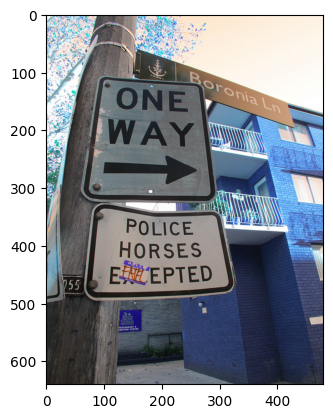

In [8]:
v = Visualizer(img_preview, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
v = v.draw_instance_predictions(instances)
plt.imshow(v.get_image()[:, :, ::-1])
plt.show(); plt.close()